In [ ]:
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/test.pt

--2021-10-18 06:48:47--  https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt [following]
--2021-10-18 06:48:47--  https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47520431 (45M) [application/octet-stream]
Saving to: ‘training.pt’

training.pt         100%[===================>]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [ ]:
import matplotlib.pyplot as plt
import tqdm

In [ ]:
X_train, _ = torch.load('training.pt')

In [ ]:
def normalise_x(x):
    return (x - x.min())/(x.max() - x.min())

def salt_n_pepper_noise(x):
    return x + torch.rand(x.size())

def gaussian_noise(x):
    return x + torch.normal(0, 0.15, size= x.size())

In [ ]:
X_train = normalise_x(X_train)

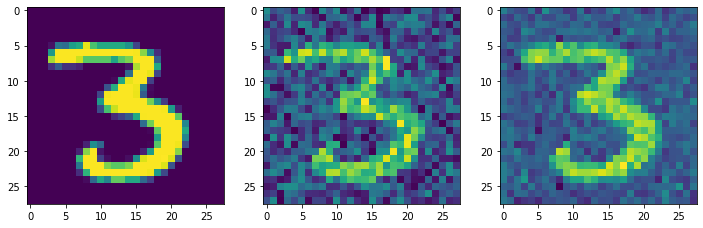

In [ ]:
id=12
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(X_train[id])
plt.subplot(1,3,2)
plt.imshow(salt_n_pepper_noise(X_train[id]))
plt.subplot(1,3,3)
plt.imshow(gaussian_noise(X_train[id]))

In [ ]:
X_train[12].size()

torch.Size([28, 28])

In [ ]:
class AE_CNN(nn.Module):

    def __init__(self):

        super(AE_CNN, self).__init__()

        self.enc_conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        self.dec_convt1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.dec_convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=2, padding=0, stride=2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


    def encoder(self, x):

        x = self.enc_conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.enc_conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.size())
        return x

    def decoder(self, x):

        x = self.dec_convt1(x)
        x = F.relu(x)
        x = self.dec_convt2(x)
        x = F.relu(x)
        # print(x.size())
        return x
    
    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
AE_cnn_model = AE_CNN()
AE_cnn_model = AE_cnn_model.to(device)

ae_target = X_train.reshape(-1,1,28,28)
ae_train_SNP_noise = salt_n_pepper_noise(normalise_x(ae_target)) #reshaped already 

train_loader = DataLoader(TensorDataset(ae_train_SNP_noise, ae_target), shuffle=True, batch_size = 64)
opt = Adam( params = AE_cnn_model.parameters(), lr = 0.0001)


In [ ]:

for epoch in range(100):

    training_loss = 0.0

    for batch, target in train_loader:

        batch = batch.to(device)
        target = target.to(device)

        output = AE_cnn_model(batch)
        loss = F.mse_loss(output, target)

        training_loss += loss.item()

        loss.backward()
        opt.step()
        opt.zero_grad()

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} Training loss:{training_loss}")


Epoch: 0 Training loss:7.549606590531766
Epoch: 10 Training loss:5.844519617501646
Epoch: 20 Training loss:5.350482913199812
Epoch: 30 Training loss:5.088572239037603
Epoch: 40 Training loss:4.941849590744823
Epoch: 50 Training loss:4.84621649235487
Epoch: 60 Training loss:4.775631188414991
Epoch: 70 Training loss:4.719723703339696
Epoch: 80 Training loss:4.6706291497685015
Epoch: 90 Training loss:4.633138186298311
Epoch: 100 Training loss:4.603189725894481


KeyboardInterrupt: ignored

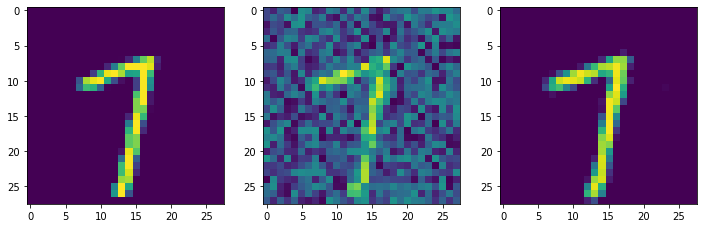

In [ ]:
sample_img = ae_target[42]
noised_sample_img = ae_train_SNP_noise[42].reshape(28,28)
denoised_sample_img = AE_cnn_model(ae_train_SNP_noise[42].reshape(-1,1,28,28).to(device)).reshape(28,28)

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(sample_img[0])
plt.subplot(1,3,2)
plt.imshow(noised_sample_img)
plt.subplot(1,3,3)
plt.imshow(denoised_sample_img.detach().cpu())

In [ ]:
ssample_img[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
denoised_sample_img.size()

torch.Size([28, 28])